In [201]:
# imports 

import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np 
import re 
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# general plot settings 
sns.set(rc={'figure.figsize':(16,5)})
sns.set_style('ticks')

In [3]:
# functions

# makes a date time 'grouped' series 
def make_date_time (df):
    df['DateTime'] = pd.to_datetime(df.Date + ' ' + df.Time)
    df['hour'] = df.DateTime.dt.hour
    df['day'] = df.DateTime.dt.day_name()
    df['5_min'] = df.DateTime.dt.minute
    return df 

# transformes '00:01:15' 5 min string to 000115 int to preserve the hour factor  
def make_min_string(Time_string):
    a = re.findall('[^:]+',Time_string)
    b = ''.join(a)
    return int(b)

# makes an new 5_min column with hour indication 
def make_5_min_int_column(df):
    time_list = list(df.Time)
    time_list_2 = [make_min_string(time_list[i]) for i in range(len(time_list))]
    df['5_in_sec'] = time_list_2
    return df

# make the hour column in the same sec scale as the min column 
def tranform_hour_in_sec_scale (df):
    hour_list = [list(df.hour)[i]*10000 for i in range(len(list(df.hour)))]
    df['hour_in_sec'] = hour_list
    return df
    
# selects the relevenat columns
def select_relavant_columns(df):
    return df[['DateTime','day', 'hour_in_sec','5_in_sec', 'W1','Wh1','Frequency']]

# strandformes the relevant columns into numeric columns                
def make_numeric (df):
    df[['Frequency','W1','Wh1']] = df[['Frequency','W1','Wh1']].apply(pd.to_numeric,errors='coerce')
    return df 
              
# alle functions together in the right order                
def make_cleaned_df (dataframe):
    df_1 = make_date_time(dataframe)
    df_2 = make_5_min_int_column(df_1)
    df_3 = tranform_hour_in_sec_scale (df_2)
    df_4 = select_relavant_columns(df_3)
    df_5 = make_numeric(df_4)
    return df_5

# creating a weekend data frame
def make_weekend(df):
    df = df.loc[(df['day']=='Saturday') | (df['day']=='Sunday')]
    return df

# creating a week data frame
def make_week(df):
    df = df.loc[~((df['day']=='Saturday') | (df['day']=='Sunday'))]
    return df

# add domies to al rows of the df per house 
def concat_dummies(df_house, index_house, df_dummies):
    columns=data_features_dubbies_2.columns
    for i in range(len(columns)):
        dummie_list = list(data_features_dubbies_2.T[index_house])
        row = dummie_list[i]
        df_house[str(columns[i])]= row
    return df_house

def make_dummy_from_watage_df(df, columns_dummies):
    df['W binned'] = pd.cut(df['W1'], 4, labels=["low","medium", "high", "congestion zone"])
    df2 = df[dummy_columns]
    df2['hour_in_sec'] = df2['hour_in_sec'].astype(str)
    x = pd.get_dummies(df2, drop_first=True)
    return x 


In [4]:
# loeading the general feature data and make then into dummies for the random forrest algorithm 

data_features = pd.read_excel("data/Feature_houses_def.xlsx")
data_features.index =data_features['House']
data_features

columns = ['number of people per house', 'bedrooms', 'bathrooms', 
       'Laundry room', 'entrance hall', 'Corridor', 'Garage',
       'Garden', 'Storage',  'Dryer',
       'Dishwasher ', 'Cleaner', 'Tv', 'Kettle', 'Freezer',
       'Water heater', 'Hob', 'Oven', 'Fridge', 'Extractor', 'Hair dryer',
       'Laptop',  'Spring', 'Summer', 'Autumn',
       'Winter']

dummy_columns = ['day', 'House','hour_in_sec', 'number of people per house_3', 'number of people per house_4',
       'bedrooms_3', 'bedrooms_4', 'bathrooms_2', 'bathrooms_3',
       'Laundry room_1', 'entrance hall_1', 'Corridor_1', 'Garage_1',
       'Garden_1', 'Storage_1', 'Dryer_1.0', 'Dishwasher _1.0', 'Cleaner_1.0',
       'Tv_2.0', 'Tv_3.0', 'Tv_4.0', 'Tv_5.0', 'Kettle_1.0', 'Kettle_nan',
       'Freezer_1.0', 'Water heater_1.0', 'Water heater_2.0', 'Hob_1.0',
       'Oven_1.0', 'Fridge_2.0', 'Extractor_1.0', 'Hair dryer_1.0',
       'Laptop_2.0', 'Laptop_3.0', 'Spring_1', 'Summer_1', 'Autumn_1',
       'Winter_1', 'W binned', 'W1']


data_features_2 = data_features[columns][:-1]
data_features_3 = data_features_2.astype(str)

data_features_dubbies = pd.get_dummies(data_features_3, drop_first=True)
data_features_dubbies_2 =data_features_dubbies.reset_index()
data_features_dubbies_2

,House,number of people per house_3,number of people per house_4,bedrooms_3,bedrooms_4,bathrooms_2,bathrooms_3,Laundry room_1,entrance hall_1,Corridor_1,...,Oven_1.0,Fridge_2.0,Extractor_1.0,Hair dryer_1.0,Laptop_2.0,Laptop_3.0,Spring_1,Summer_1,Autumn_1,Winter_1
0,House 1,1,0,1,0,0,1,1,1,1,...,1,0,1,1,0,1,0,1,0,0
1,House 2,0,1,0,1,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,House 3,0,0,1,0,0,1,1,1,1,...,1,0,1,1,1,0,0,0,0,1
3,House 4,0,1,1,0,1,0,1,1,1,...,0,1,1,0,0,0,0,0,0,1
4,House 5,1,0,0,0,0,0,0,1,0,...,1,0,1,1,0,0,0,1,0,0
5,House 7,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0
6,House 8,1,0,1,0,1,0,1,1,0,...,0,1,1,0,0,0,0,1,0,0
7,House 9,1,0,1,0,1,0,1,1,0,...,0,1,1,0,0,0,0,0,0,1
8,House 6,0,0,0,0,1,0,1,1,1,...,1,0,1,1,1,0,1,1,1,1


In [5]:

# Load Private Home_1
data_load = pd.read_excel("data/Private Home_1_2011_June_03_to_17.xls", sheet_name='Trend', header=6)[2:]
data_1 = make_cleaned_df(data_load)
data_house_1 = concat_dummies(data_1, 0, data_features_dubbies_2)
data_house_1_def = make_dummy_from_watage_df(data_house_1, dummy_columns)
data_house_1_def['house_data_set'] = '1'

# Load Private Home_2
data_load = pd.read_excel("data/Private Home_2_2012_July_16_to_26.xls", sheet_name='Trend', header=6)[2:]
data_2 = make_cleaned_df(data_load)
data_house_2 = concat_dummies(data_2, 1, data_features_dubbies_2)
data_house_2_def = make_dummy_from_watage_df(data_house_2, dummy_columns)
data_house_2_def['house_data_set'] = '2'

# Load Private Home_3
data_load = pd.read_excel("data/Private Home_3_2013_January_23_to_February_07.xls", sheet_name='Trend', header=6)[2:]
data_3 = make_cleaned_df(data_load)
data_house_3 = concat_dummies(data_3, 2, data_features_dubbies_2)
data_house_3_def = make_dummy_from_watage_df(data_house_2, dummy_columns)
data_house_3_def['house_data_set'] = '3'

# Load Private Home_4
data_load = pd.read_excel("data/Private Home_4_2014_January_06_to_30.xls", sheet_name='Trend', header=6)[2:]
data_4 = make_cleaned_df(data_load)
data_house_4 = concat_dummies(data_4, 3, data_features_dubbies_2)
data_house_4_def = make_dummy_from_watage_df(data_house_2, dummy_columns)
data_house_4_def['house_data_set'] = '4'

# Load Private Home_5
data_load = pd.read_excel("data/Private Home_5_2011_August_04_to_18.xlsx", sheet_name='Trend', header=6)[2:]
data_5 = make_cleaned_df(data_load)
data_house_5 = concat_dummies(data_5, 4, data_features_dubbies_2)
data_house_5_def = make_dummy_from_watage_df(data_house_2, dummy_columns)
data_house_5_def['house_data_set'] = '5'

# Load Private Home_7
data_load = pd.read_excel("data/Private Home_7_2011_September_26_to_October_03.xlsx", sheet_name='Trend', header=6)[2:]
data_7 = make_cleaned_df(data_load)
data_house_7 = concat_dummies(data_7, 6, data_features_dubbies_2)
data_house_7def = make_dummy_from_watage_df(data_house_2, dummy_columns)
data_house_7def['house_data_set'] = '7'

# Load Private Home_8
data_load = pd.read_excel("data/Private Home_8_2012_June_01_to_15.xlsx", sheet_name='Trend', header=6)[2:]
data_8 = make_cleaned_df(data_load)
data_house_8 = concat_dummies(data_8, 7, data_features_dubbies_2)
data_house_8def = make_dummy_from_watage_df(data_house_2, dummy_columns)
data_house_8def['house_data_set'] = '8'

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [6]:
# Concat Home_1 and 2
df_combined= pd.concat([data_house_1_def, data_house_2_def, 
                        data_house_3_def, data_house_4_def, 
                       data_house_7def, data_house_8def])

In [19]:
test = pd.get_dummies(df_combined, drop_first=True)
# drop the watage and the other binnen Watage beacause these are causing data leackages 
test2 = test.drop(["W binned_high", "W binned_medium", "W1"], axis = 1)
test2['W binned_congestion zone'].value_counts()

0    18977
1       33
Name: W binned_congestion zone, dtype: int64

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


confusion matrix: 
 [[3794    3]
 [   4    1]]

accuracy_score: 
 0.9981588637559179

balanced accuracy_score: 
 0.5996049512773242

recal score 0.2


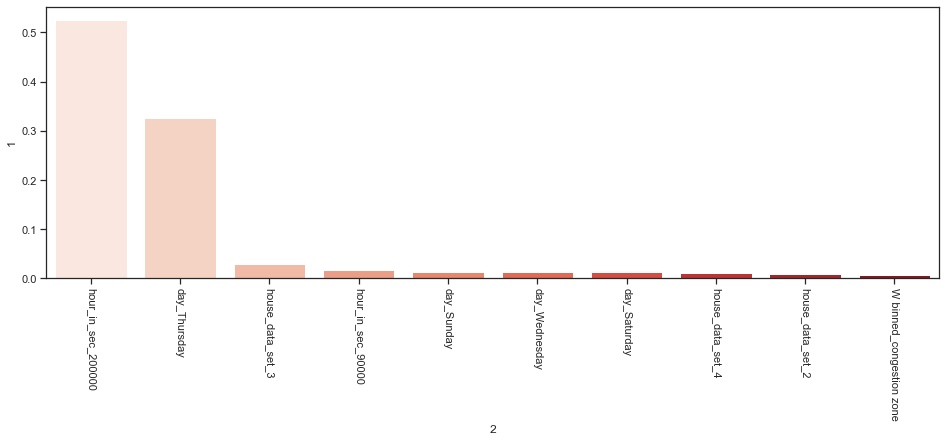

In [37]:
# train test split 
y = test2['W binned_congestion zone'] 
X = test2.drop(["W binned_congestion zone"], axis=1) 
#X = test2[['hour_in_sec_200000','day_Thursday']]
# shufle or not? because it is taie based 
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, shuffle=True)

# fit the model with the train data 
forest = RandomForestClassifier() 
congestion_rf = forest.fit(X_train, y_train)
y_pred_test_rf = congestion_rf.predict(X_test)

# check the importance of the features 
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# collect the feature ranking incl (column titles) in a dataframe to plot 
feature_importance_list = []
for f in range(X.shape[1]):
    feature_importance_list.append((indices[f], importances[indices[f]], test2.columns[indices[f]]))
    
df_test = pd.DataFrame(feature_importance_list)
ax = sns.barplot(x=2, y=1, data=df_test[:10],  ci=std[indices], palette="Reds")
plt.setp(ax.get_xticklabels(), rotation=-90)


# print out the scores --> recal beacuse its more important to have the least False negative 
print("confusion matrix: \n", confusion_matrix(y_test, y_pred_test_rf))
print("\naccuracy_score: \n",accuracy_score(y_test, y_pred_test_rf))
print("\nbalanced accuracy_score: \n", balanced_accuracy_score(y_test, y_pred_test_rf))
print("\nrecal score", recall_score(y_test, y_pred_test_rf))
#print(feature_importance_list)

In [38]:
y_test.value_counts()

0    3797
1       5
Name: W binned_congestion zone, dtype: int64

In [39]:
df_combined_2 = 

,number of people per house_3,number of people per house_4,bedrooms_3,bedrooms_4,bathrooms_2,bathrooms_3,Laundry room_1,entrance hall_1,Corridor_1,Garage_1,...,hour_in_sec_40000,hour_in_sec_50000,hour_in_sec_60000,hour_in_sec_70000,hour_in_sec_80000,hour_in_sec_90000,W binned_medium,W binned_high,W binned_congestion zone,house_data_set
2,1,0,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
5,1,0,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
6,1,0,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,0,1,0,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,8
2936,0,1,0,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,8
2937,0,1,0,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,8
2938,0,1,0,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,8


In [54]:
data_1

,DateTime,day,hour_in_sec,5_in_sec,W1,Wh1,Frequency,House,number of people per house_3,number of people per house_4,...,Extractor_1.0,Hair dryer_1.0,Laptop_2.0,Laptop_3.0,Spring_1,Summer_1,Autumn_1,Winter_1,W binned,house_data_set
2,2011-03-06 00:00:00,Sunday,0,0,386.96,32.35,49.97,House 1,1,0,...,1,1,0,1,0,1,0,0,low,1
3,2011-03-06 00:05:00,Sunday,0,500,182.80,47.59,50.00,House 1,1,0,...,1,1,0,1,0,1,0,0,low,1
4,2011-03-06 00:10:00,Sunday,0,1000,265.95,69.75,50.01,House 1,1,0,...,1,1,0,1,0,1,0,0,low,1
5,2011-03-06 00:15:00,Sunday,0,1500,277.02,92.83,50.00,House 1,1,0,...,1,1,0,1,0,1,0,0,low,1
6,2011-03-06 00:20:00,Sunday,0,2000,257.19,114.27,50.00,House 1,1,0,...,1,1,0,1,0,1,0,0,low,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4317,2011-06-17 23:35:00,Friday,230000,233500,36.84,79846.59,50.01,House 1,1,0,...,1,1,0,1,0,1,0,0,low,1
4318,2011-06-17 23:40:00,Friday,230000,234000,36.96,79849.67,50.00,House 1,1,0,...,1,1,0,1,0,1,0,0,low,1
4319,2011-06-17 23:45:00,Friday,230000,234500,36.80,79852.74,50.02,House 1,1,0,...,1,1,0,1,0,1,0,0,low,1
4320,2011-06-17 23:50:00,Friday,230000,235000,36.71,79855.80,50.03,House 1,1,0,...,1,1,0,1,0,1,0,0,low,1


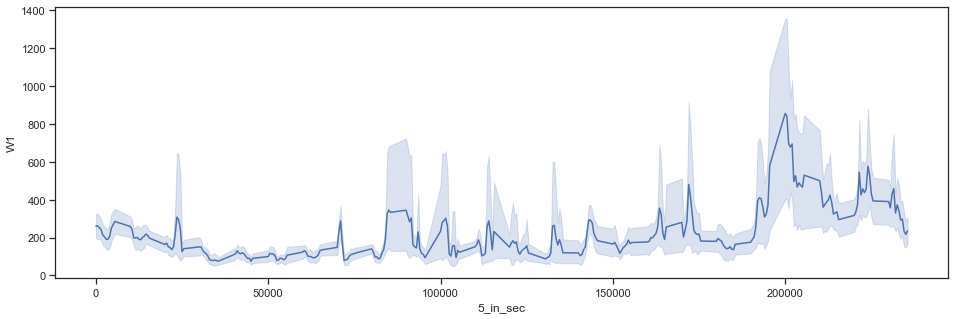

In [56]:
Total_average_min = sns.lineplot(x='5_in_sec', y="W1", data=data_1)
#Total_average_min.axes.set_title("HOUSE 1:     3 pers, 7 summer days, 11 rooms, 16 appliances", fontsize=20, loc = 'left')
#Total_average_hour = sns.lineplot(x='hour_in_sec', y="W1", data=data_1)

In [ ]:
Total_average_min = sns.lineplot(x='5_in_sec', y="W1", data=data_2)
Total_average_min.axes.set_title("HOUSE 2:     4 pers, 10 summer days, 12 rooms, 15 appliances", fontsize=20, loc = 'left')
Total_average_hour = sns.lineplot(x='hour_in_sec', y="W1", data=data_2)

In [ ]:
Total_average_min = sns.lineplot(x='5_in_sec', y="W1", data=data_3) 
Total_average_min.axes.set_title("HOUSE 3:     2 pers, 15 winter days, 11 rooms, 17 appliances", fontsize=20, loc = 'left')
Total_average_hour = sns.lineplot(x='hour_in_sec', y="W1", data=data_3)

In [ ]:
Total_average_min = sns.lineplot(x='5_in_sec', y="W1", data=data_4) 
Total_average_min.axes.set_title("HOUSE 4:     4 pers, 24 winter days, 13 rooms, 17 appliances", fontsize=20, loc = 'left')
Total_average_hour = sns.lineplot(x='hour_in_sec', y="W1", data=data_4)

In [ ]:
Total_average_min = sns.lineplot(x='5_in_sec', y="W1", data=data_5) 
Total_average_min.axes.set_title("HOUSE 5:     3 pers, 14 summer days, 7 rooms, 17 appliances", fontsize=20, loc = 'left')
Total_average_hour = sns.lineplot(x='hour_in_sec', y="W1", data=data_5)

In [ ]:
Total_average_min = sns.lineplot(x='5_in_sec', y="W1", data=data_7) 
Total_average_min.axes.set_title("HOUSE 7(student):     2 pers, 7 autum days, 5 rooms, 14 appliances", fontsize=20, loc = 'left')
Total_average_hour = sns.lineplot(x='hour_in_sec', y="W1", data=data_7)

In [ ]:
Total_average_min = sns.lineplot(x='5_in_sec', y="W1", data=data_8)
Total_average_min.axes.set_title("HOUSE 8:     3 pers, 14 summer days, 12 rooms, 16 appliances", fontsize=20, loc = 'left') 
Total_average_hour = sns.lineplot(x='hour_in_sec', y="W1", data=data_8)

In [152]:
data_1['house_data_set'] = '1'
data_1_deff = data_1[['5_in_sec','hour_in_sec', 'W1', 'house_data_set', 'day', 'DateTime']]
data_2['house_data_set'] = '2'
data_2_deff = data_2[['5_in_sec','hour_in_sec',  'W1', 'house_data_set', 'day', 'DateTime']]
data_3['house_data_set'] = '3'
data_3_deff = data_3[['5_in_sec','hour_in_sec',  'W1', 'house_data_set', 'day', 'DateTime']]
data_4['house_data_set'] = '4'
data_4_deff = data_4[['5_in_sec','hour_in_sec',  'W1', 'house_data_set', 'day', 'DateTime']]
data_5['house_data_set'] = '5'
data_5_deff = data_5[['5_in_sec','hour_in_sec',  'W1', 'house_data_set', 'day', 'DateTime']]
data_7['house_data_set'] = '7'
data_7_deff = data_7[['5_in_sec','hour_in_sec',  'W1', 'house_data_set', 'day', 'DateTime']]
data_8['house_data_set'] = '8'
data_8_deff = data_8[['5_in_sec','hour_in_sec',  'W1', 'house_data_set', 'day', 'DateTime']]


,5_in_sec,hour_in_sec,W1,house_data_set,day,DateTime
2235,180500,180000,176.38,1,Thursday,2011-10-06 18:05:00
2236,181000,180000,190.04,1,Thursday,2011-10-06 18:10:00
2237,181500,180000,185.72,1,Thursday,2011-10-06 18:15:00
2238,182000,180000,147.85,1,Thursday,2011-10-06 18:20:00
2239,182500,180000,75.36,1,Thursday,2011-10-06 18:25:00
...,...,...,...,...,...,...
4005,213500,210000,348.85,8,Thursday,2012-06-14 21:35:00
4006,214000,210000,176.05,8,Thursday,2012-06-14 21:40:00
4007,214500,210000,57.57,8,Thursday,2012-06-14 21:45:00
4008,215000,210000,248.82,8,Thursday,2012-06-14 21:50:00


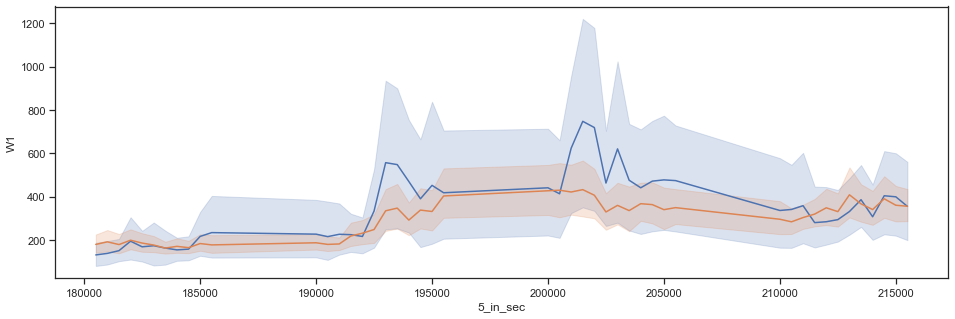

In [153]:
df_combined_time_serie = pd.concat([data_1_deff, data_2_deff, 
                                   data_3_deff, data_4_deff, 
                                   data_5_deff, data_7_deff, 
                                   data_8_deff])

hour_range_19_and_21 = df_combined_time_serie[
    (df_combined_time_serie['5_in_sec'] > 180000) & (df_combined_time_serie['5_in_sec']  < 220000)] 
hour_range_19_and_21_thursday = hour_range_19_and_21[hour_range_19_and_21.day == 'Thursday']

df_combined_time_serie_def = df_combined_time_serie[df_combined_time_serie.day == 'Thursday']

sns.lineplot(x='5_in_sec', y="W1", data=hour_range_19_and_21_thursday)
sns.lineplot(x='5_in_sec', y="W1", data=hour_range_19_and_21)

hour_range_19_and_21_thursday

In [195]:
#train_index = int(hour_range_19_and_21_thursday.shape[0]*0.8)
#hour_range_19_and_21_thursday.index = hour_range_19_and_21_thursday['DateTime']
train_index = int(df_combined_time_serie_def.shape[0]*0.5)
df_combined_time_serie_def.index = df_combined_time_serie_def['DateTime']

#df_combined_time_serie_def.index = df_combined_time_serie_def['5_in_sec']
#train = hour_range_19_and_21_thursday['W1'][train_index :]
#test = hour_range_19_and_21_thursday['W1'][:train_index ]
train = df_combined_time_serie_def['W1'][train_index :]
test = df_combined_time_serie_def['W1'][:train_index ]
test

DateTime
2011-10-06 00:00:00    376.21
2011-10-06 00:05:00    507.38
2011-10-06 00:10:00    361.87
2011-10-06 00:15:00    268.46
2011-10-06 00:20:00    394.09
                        ...  
2011-09-08 09:10:00      0.00
2011-09-08 09:15:00      0.00
2011-09-08 09:20:00    636.46
2011-09-08 09:25:00     23.30
2011-09-08 09:30:00    198.46
Name: W1, Length: 2477, dtype: float64

In [204]:
model = AR(train)
model_fit = model.fit()

print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
print('The first test value in Sales :',test.values[0],'and its Predicted value : ',predictions.values[0])

Lag: 27
Coefficients: const     48.465621
L1.W1      0.634417
L2.W1      0.130842
L3.W1      0.012182
L4.W1     -0.034359
L5.W1      0.016904
L6.W1     -0.014640
L7.W1     -0.041709
L8.W1      0.050718
L9.W1     -0.038549
L10.W1     0.001611
L11.W1     0.029902
L12.W1    -0.039659
L13.W1     0.049860
L14.W1    -0.016531
L15.W1    -0.023754
L16.W1     0.026468
L17.W1    -0.019131
L18.W1    -0.025781
L19.W1     0.070522
L20.W1    -0.042204
L21.W1     0.008029
L22.W1     0.019677
L23.W1    -0.040001
L24.W1     0.018859
L25.W1     0.000219
L26.W1    -0.001822
L27.W1     0.003154
dtype: float64
The first test value in Sales : 376.21 and its Predicted value :  159.38877795834728


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,Predict,Test,difference
0,159.388778,376.21,-216.821222
1,189.746550,507.38,-317.633450
2,139.304801,361.87,-222.565199
3,178.674345,268.46,-89.785655
4,177.402767,394.09,-216.687233
...,...,...,...
2472,183.044521,0.00,183.044521
2473,183.044521,0.00,183.044521
2474,183.044521,636.46,-453.415479
2475,183.044521,23.30,159.744521


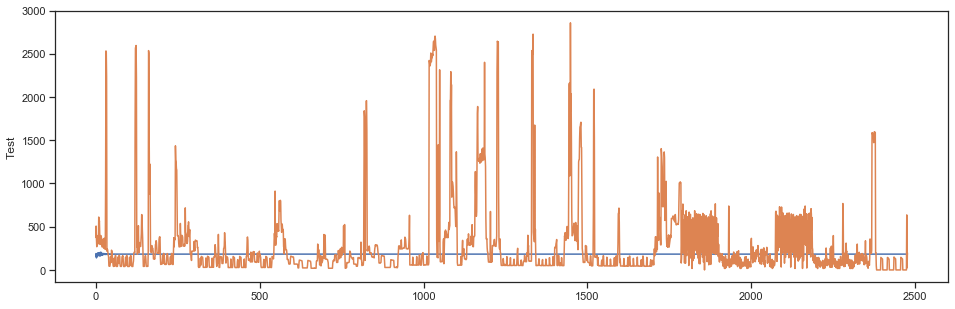

In [199]:
'''plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()'''

AR_df = pd.DataFrame(test.values, predictions.values)
predict_test = AR_df.reset_index()
predict_test.columns = ["Predict", "Test"]
predict_test

sns.lineplot(x=predict_test.index, y="Predict", data=predict_test)
sns.lineplot(x=predict_test.index, y="Test", data=predict_test)
predict_test["difference"] = predict_test['Predict']-predict_test['Test']
predict_test

In [207]:
df_combined_time_serie_def['W1'].values

array([376.21, 507.38, 361.87, ..., 270.85, 323.37, 130.3 ])

Test MSE: 137645.834


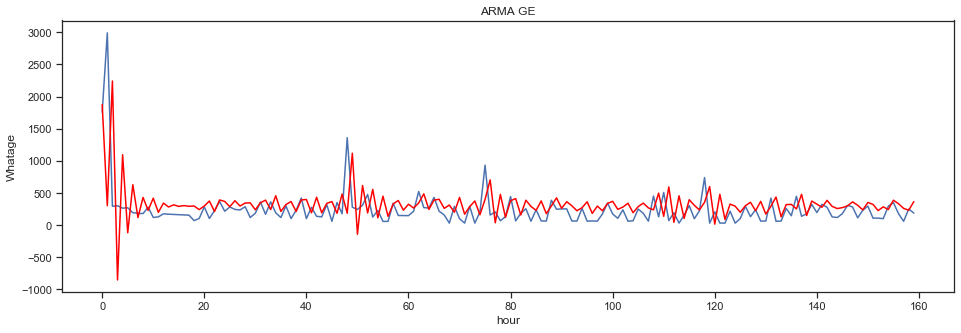

In [218]:
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error

#X = df_combined_time_serie_def['W1'].values
X = hour_range_19_and_21_thursday['W1'].values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model =ARMA(history, order=(0, 1))
    model_fit = model.fit(disp=False)
    output = model_fit.predict(start=len(history), end=len(history)+len(test)-1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.title("ARMA GE")
plt.xlabel('hour')
plt.ylabel('Whatage')
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()





,Predict,Test
0,165.941658,12.27
1,135.472217,12.12
2,155.486033,12.29
3,142.290730,12.29
4,150.968660,12.34
...,...,...
986,160.247323,441.45
987,405.436647,142.86
988,68.077864,270.85
989,356.723149,323.37


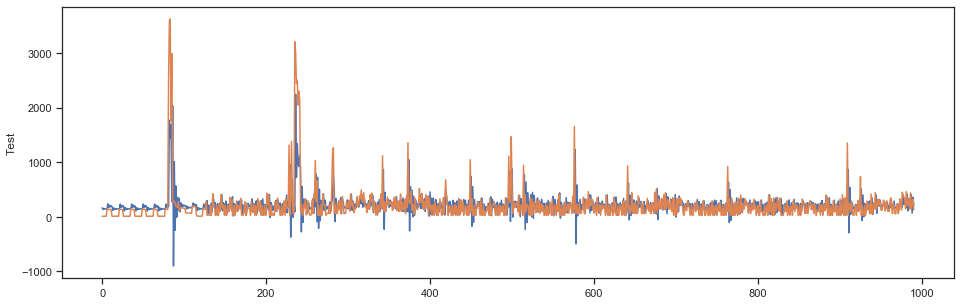

In [217]:
df_predcict = pd.DataFrame(test, predictions)
df_predcict_2 = df_predcict.reset_index()
df_predcict_2.columns = ["Predict", "Test"]

sns.set(rc={'figure.figsize':(16,5)})
sns.set_style('ticks')

sns.lineplot(x=df_predcict_2.index, y="Predict", data=df_predcict_2)
sns.lineplot(x=df_predcict_2.index, y="Test", data=df_predcict_2)


df_predcict_2


In [200]:
# AR example
from statsmodels.tsa.ar_model import AR
from random import random
# contrived dataset
#data = [x + random() for x in range(1, 100)]
# fit model
model = AR(hour_range_19_and_21_def )
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(hour_range_19_and_21_def ), len(hour_range_19_and_21_def))
print(yhat)

799    245.054505
dtype: float64


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [206]:
model = ARIMA(df_combined_time_serie_def['W1'], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D.W1   No. Observations:                 4953
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -34192.548
Method:                       css-mle   S.D. of innovations            240.915
Date:                Fri, 29 Nov 2019   AIC                          68399.097
Time:                        17:15:43   BIC                          68444.651
Sample:                             1   HQIC                         68415.071
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0405      2.061     -0.020      0.984      -4.079       3.998
ar.L1.D.W1    -0.2130      0.014    -15.167      0.000      -0.241      -0.186
ar.L2.D.W1    -0.1405      0.014     -9.822      0.0

NameError: name 'DataFrame' is not defined